**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [35]:
import pandas as pd, numpy as np, itertools, matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

# Models and Parameter Grids

In [36]:
dt_clf  = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
lr_clf  = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Note: We insert a VarianceThreshold step named 'var_thresh' to remove constant/near-constant features
param_grid_dt = {
    'feature_selection__k': [10, 20, 40, 'all'],
    'classifier__max_depth': [None, 3, 5, 8, 12],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}
param_grid_knn = {
    'feature_selection__k': [10, 20, 40, 'all'],
    'classifier__n_neighbors': [3, 5, 7, 11, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}
param_grid_lr = {
    'feature_selection__k': [10, 20, 40, 'all'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear']
}

classifiers_to_tune = [
    (dt_clf,  param_grid_dt, 'Decision Tree'),
    (knn_clf, param_grid_knn, 'kNN'),
    (lr_clf,  param_grid_lr, 'Logistic Regression')
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [ ]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [42]:
def load_hr_attrition():
    # Corrected the file path to load from the root directory
    df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    X = df.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = df['Attrition']
    X = pd.get_dummies(X, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    print("IBM HR Attrition loaded. Train:", X_train.shape, "Test:", X_test.shape)
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [ ]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [ ]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [34]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    print("\n" + "="*60)
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print("="*60)
    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for base_clf, grid, name in classifiers_to_tune:
        print(f"\n--- Manual Grid for {name} ---")
        grid = adjust_k_grid(grid, n_features)
        keys = list(grid.keys())
        combos = list(itertools.product(*[grid[k] for k in keys]))

        best_score, best_params = -1.0, None
        for combo in combos:
            params = dict(zip(keys, combo))
            fold_scores = []
            for tr, va in cv.split(X_train, y_train):
                X_tr, X_va = X_train.iloc[tr], X_train.iloc[va]
                y_tr, y_va = y_train.iloc[tr], y_train.iloc[va]

                pipe = make_pipeline(deepcopy(base_clf))
                pipe.set_params(**params)
                pipe.fit(X_tr, y_tr)
                y_proba = pipe.predict_proba(X_va)[:, 1]
                fold_scores.append(roc_auc_score(y_va, y_proba))
            mean_auc = float(np.mean(fold_scores))
            if mean_auc > best_score:
                best_score, best_params = mean_auc, params

        print(f"Best params: {best_params} | Best CV AUC: {best_score:.4f}")
        final_pipe = make_pipeline(deepcopy(base_clf))
        final_pipe.set_params(**best_params)
        final_pipe.fit(X_train, y_train)
        best_estimators[name] = final_pipe
    return best_estimators
    # ---------------- Helpers
def adjust_k_grid(grid, n_features):
    new = {}
    for p, vals in grid.items():
        if p == 'feature_selection__k':
            ks = []
            for v in vals:
                ks.append(n_features if v == 'all' else min(int(v), n_features))
            new[p] = sorted(set(ks))
        else:
            new[p] = vals
    return new

def make_pipeline(base_clf):
    return Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=False)),     # safe for sparse matrices
        ('var_thresh', VarianceThreshold(threshold=0.0)),  # drop constant cols
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('classifier', base_clf)
    ])

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [39]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print("\n" + "="*60)
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print("="*60)
    results = {}
    n_features = X_train.shape[1]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for base_clf, grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")
        grid = adjust_k_grid(grid, n_features)
        pipe = make_pipeline(base_clf)
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            refit=True,
            verbose=0
        )
        gs.fit(X_train, y_train)
        print(f"Best params: {gs.best_params_} | Best CV AUC: {gs.best_score_:.4f}")
        results[name] = {
            'best_estimator': gs.best_estimator_,
            'best_score (CV)': gs.best_score_,
            'best_params': gs.best_params_
        }
    return results

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [40]:
def evaluate_models(X_train, y_train, X_test, y_test, estimators, dataset_name, method_name):
    print("\n" + "="*60)
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print("="*60)

    for name, model in estimators.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}: "
              f"Acc {accuracy_score(y_test, y_pred):.4f} | "
              f"Prec {precision_score(y_test, y_pred, zero_division=0):.4f} | "
              f"Rec {recall_score(y_test, y_pred, zero_division=0):.4f} | "
              f"F1 {f1_score(y_test, y_pred, zero_division=0):.4f} | "
              f"AUC {roc_auc_score(y_test, y_proba):.4f}")

    # Soft voting ensemble
    estimators_list = [(n, m) for n, m in estimators.items()]
    voting = VotingClassifier(estimators=estimators_list, voting='soft')
    voting.fit(X_train, y_train)
    yv = voting.predict(X_test)
    yv_proba = voting.predict_proba(X_test)[:, 1]
    print(f"\nVoting: Acc {accuracy_score(y_test, yv):.4f} | "
          f"Prec {precision_score(y_test, yv, zero_division=0):.4f} | "
          f"Rec {recall_score(y_test, yv, zero_division=0):.4f} | "
          f"F1 {f1_score(y_test, yv, zero_division=0):.4f} | "
          f"AUC {roc_auc_score(y_test, yv_proba):.4f}")

    # ROC curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for name, model in estimators.items():
        proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc_s = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_s:.3f})')
    fpr_v, tpr_v, _ = roc_curve(y_test, yv_proba)
    plt.plot(fpr_v, tpr_v, label=f'Voting (AUC={roc_auc_score(y_test, yv_proba):.3f})',
             linewidth=3, linestyle='--')
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})'); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    cm = confusion_matrix(y_test, yv)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=plt.gca(), cmap='Blues')
    plt.title(f'Voting Confusion Matrix - {dataset_name} ({method_name})')
    plt.tight_layout(); plt.show()

    return yv, yv_proba

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [27]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!



IBM HR Attrition loaded. Train: (1029, 46) Test: (441, 46)

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION

--- Manual Grid for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/

Best params: {'feature_selection__k': 10, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 5} | Best CV AUC: 0.7398

--- Manual Grid for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/

Best params: {'feature_selection__k': 46, 'classifier__n_neighbors': 15, 'classifier__weights': 'distance', 'classifier__p': 1} | Best CV AUC: 0.7519

--- Manual Grid for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
/usr/local/lib/

Best params: {'feature_selection__k': 40, 'classifier__penalty': 'l2', 'classifier__C': 1.0, 'classifier__solver': 'liblinear'} | Best CV AUC: 0.8324

EVALUATING MANUAL MODELS FOR HR ATTRITION

Decision Tree: Acc 0.8073 | Prec 0.3478 | Rec 0.2254 | F1 0.2735 | AUC 0.7137

kNN: Acc 0.8435 | Prec 0.6000 | Rec 0.0845 | F1 0.1481 | AUC 0.7291

Logistic Regression: Acc 0.8776 | Prec 0.6977 | Rec 0.4225 | F1 0.5263 | AUC 0.8215


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(



Voting: Acc 0.8662 | Prec 0.8750 | Rec 0.1972 | F1 0.3218 | AUC 0.8026


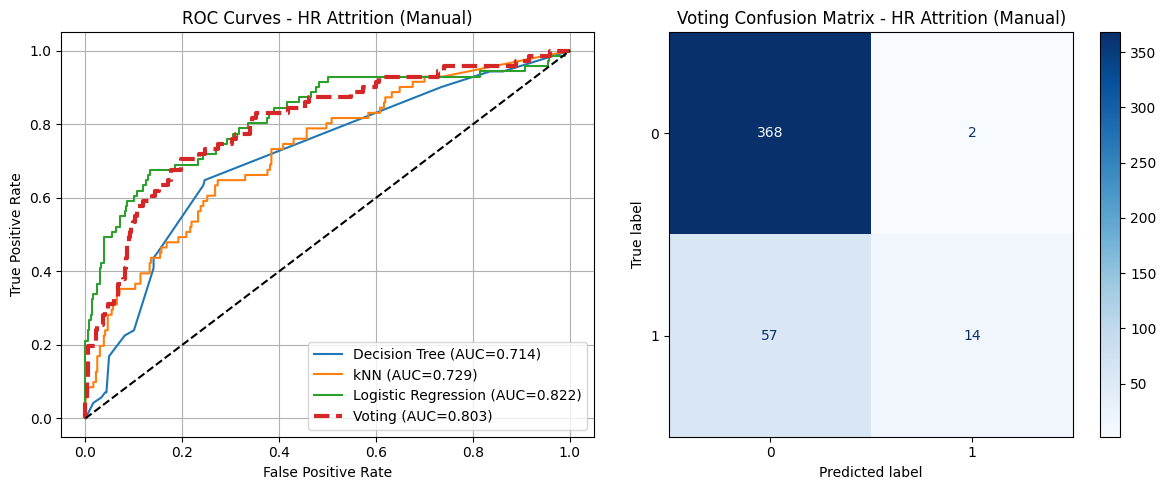


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---
Best params: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'feature_selection__k': 10} | Best CV AUC: 0.7398

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(


Best params: {'classifier__n_neighbors': 15, 'classifier__p': 1, 'classifier__weights': 'distance', 'feature_selection__k': 46} | Best CV AUC: 0.7519

--- GridSearchCV for Logistic Regression ---
Best params: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 40} | Best CV AUC: 0.8324

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

Decision Tree: Acc 0.8073 | Prec 0.3478 | Rec 0.2254 | F1 0.2735 | AUC 0.7137

kNN: Acc 0.8435 | Prec 0.6000 | Rec 0.0845 | F1 0.1481 | AUC 0.7291

Logistic Regression: Acc 0.8776 | Prec 0.6977 | Rec 0.4225 | F1 0.5263 | AUC 0.8215


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(



Voting: Acc 0.8662 | Prec 0.8750 | Rec 0.1972 | F1 0.3218 | AUC 0.8026


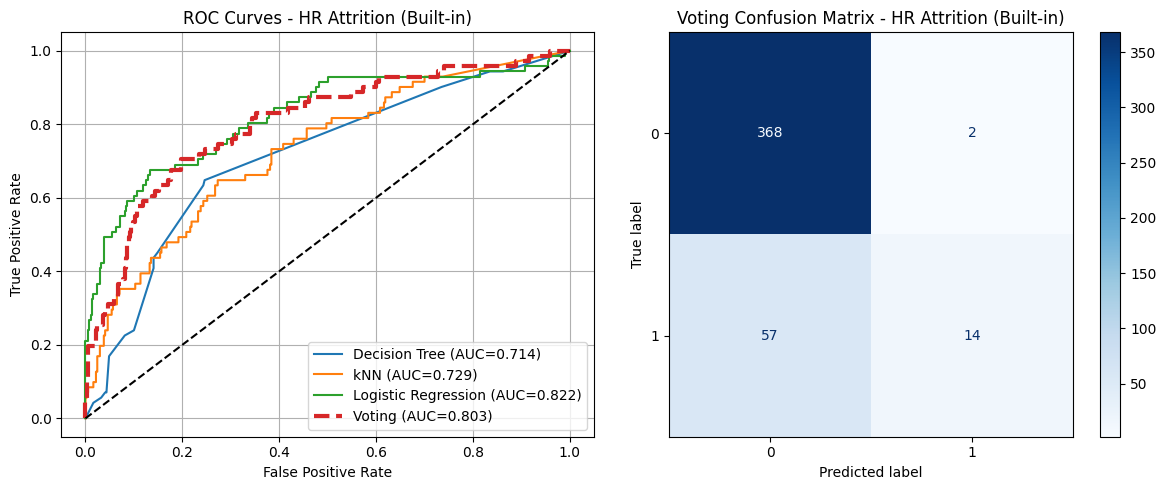

In [45]:
def run_hr_only():
    X_train, X_test, y_train, y_test, name = load_hr_attrition()

    manual_estimators = run_manual_grid_search(X_train, y_train, name)
    evaluate_models(X_train, y_train, X_test, y_test, manual_estimators, name, "Manual")

    builtin = run_builtin_grid_search(X_train, y_train, name)
    builtin_estimators = {k: v['best_estimator'] for k, v in builtin.items()}
    evaluate_models(X_train, y_train, X_test, y_test, builtin_estimators, name, "Built-in")

run_hr_only()